In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [4]:
gpu_id = 0
num_cores = 4

In [5]:
faiv.torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [6]:
nb_name = 'feature_loss_patches'

## Load Data

In [7]:
bs = 8  # batch size
size = 256  # image size
data_pth = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/baselines'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/baselines


In [8]:
tfms = [[custom_cutout()], [custom_cutout()]]

In [9]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

In [10]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [11]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(8, 9999)

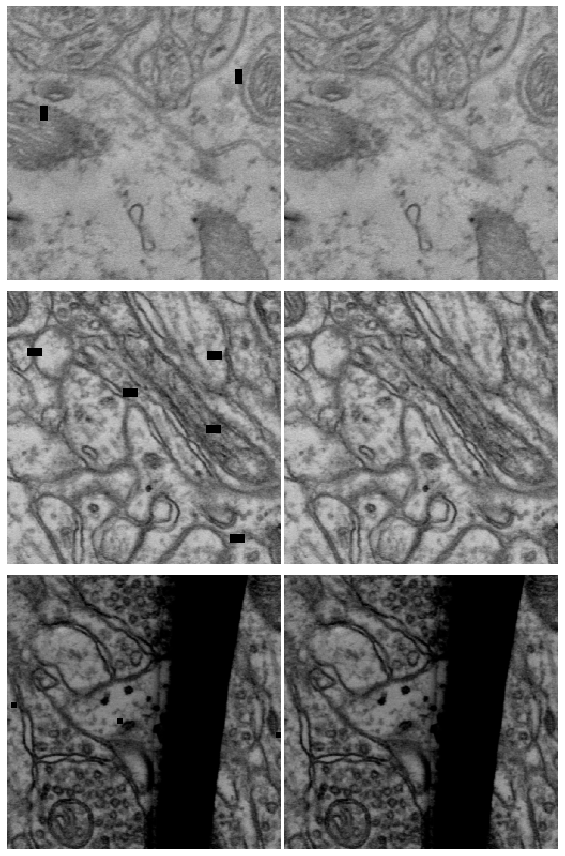

In [12]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [13]:
data = subsample(data)

In [14]:
data.c

3

In [15]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [16]:
# Batch size and number of batches
data.batch_size

8

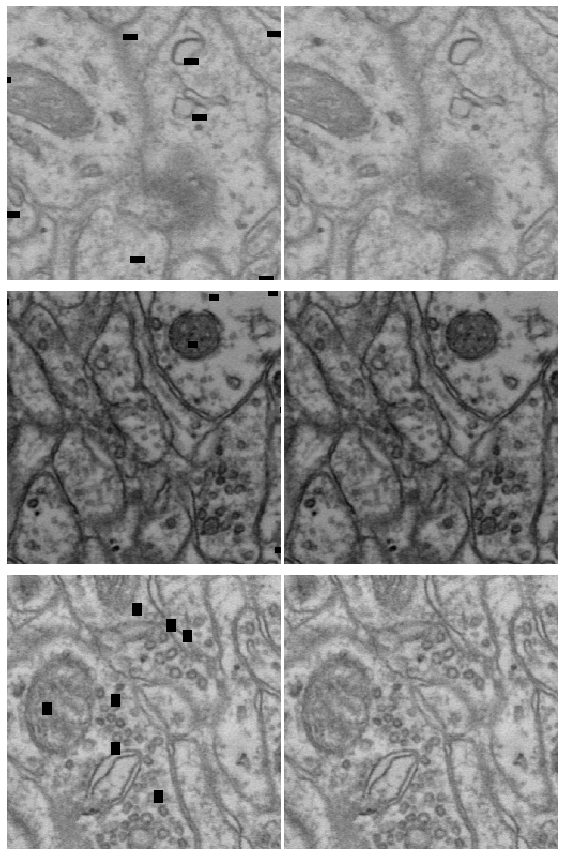

In [17]:
# Data Visualization
data.show_batch(rows=3)

# Model

## Initialization

In [18]:
arch = faiv.models.resnet34
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = faiv.unet_learner(data, arch, wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=faiv.NormType.Weight, 
                         model_dir=model_pth)
faiv.gc.collect()

25521

In [19]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/baselines


## Load Model (optional)

In [23]:
# learn.model_dir = model_pth
# learn = learn.load(f'emsynth_005_unet.5')

## Training

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


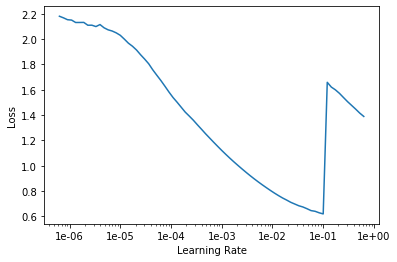

In [22]:
learn.recorder.plot()

### 1a

In [23]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}_patches_baseline.1a', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time


KeyboardInterrupt: 

In [ ]:
learn.validate()

In [ ]:
learn.show_results()

### 1b

In [ ]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


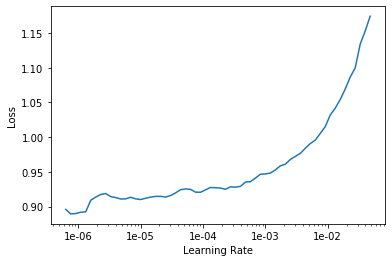

In [35]:
learn.recorder.plot()

In [ ]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}_baseline.1b', with_opt=False)

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


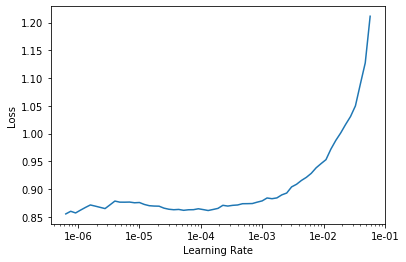

In [41]:
learn.recorder.plot()

In [ ]:
lr = slice(3e-4, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}_baseline.1c', with_opt=False)

In [ ]:
learn.validate()

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_losses()

# DEV

In [40]:
from fastai.vision import *
def get_patched_data(data_pth, hr_dir, bs, in_sz, out_sz,
                     tfms=None, num_workers=4, noise=None, max_zoom=1.1):
    src = get_patched_src(data_pth, hr_dir)
    
    data = (src
                .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP)
                .transform_y(None, size=out_sz, resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    return data


def get_patched_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src